In [1]:
%load_ext autoreload
%autoreload 2


In [59]:
from config import *
from functions import *
from sim_new import *
from read_ramses import *
import const
from scipy.interpolate import interp1d
from scipy.fft import fftn, fftfreq, fftshift
from scipy.signal.windows import blackman


In [60]:
sim = Sim(9, "fiducial", "data_d52_l1_b5.npz")
# sim = Sim(9, "mstar0p2", "data_d41_l1_b5.npz")
# sim = Sim(9, "mstar5p0", "data_d39_l1_b5.npz")


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.


### quick look

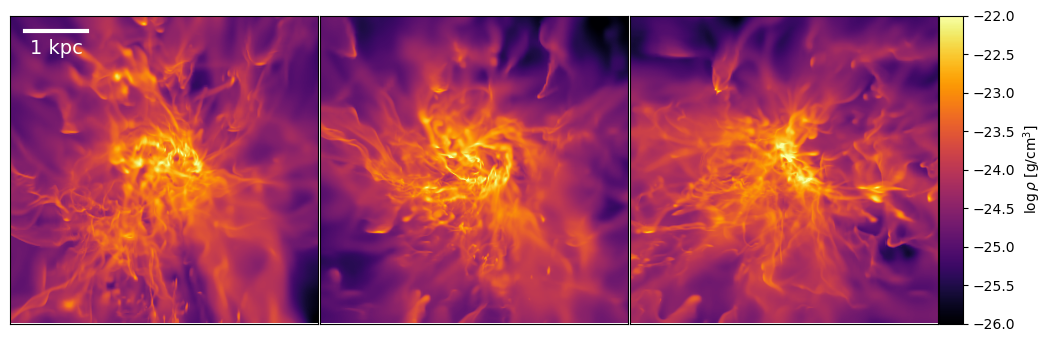

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

for i in range(3):
    img = sim.proj_axis('density', idx_axis=i)
    im = sim.plot_img(img, ax=axs[i], do_log=True, cmap='inferno', vmin=1e-26, vmax=1e-22)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
sim.add_dis_to_ax(axs[0], 1*const.kpc)
add_cbar_to_fig(im, fig, label=r'$\log \rho$ [${\rm g/cm^3}$]')


[]

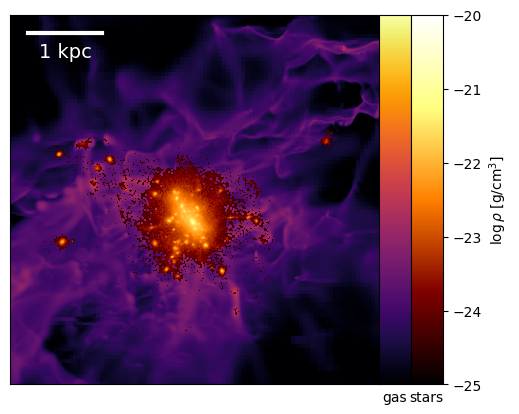

In [7]:
idx_axis = Z

fig, ax = plt.figure(), plt.gca()

img = sim.proj_axis('density', idx_axis=idx_axis)
im1 = sim.plot_img(img, ax=ax, do_log=True, cmap='inferno', vmin=1e-25, vmax=1e-20)

img = sim.proj_axis('density_star', idx_axis=idx_axis)
im2 = sim.plot_img(img, ax=ax, do_log=True, cmap='afmhot', vmin=1e-25, vmax=1e-20)
    
sim.add_dis_to_ax(ax, 1*const.kpc)
cbar = add_cbar_to_fig(im1, fig, bbox=[.8, .11, .05, .77])
cbar.ax.set_xlabel(r'gas')
cbar.ax.set_yticks([])
cbar = add_cbar_to_fig(im2, fig, bbox=[.85, .11, .05, .77], label=r'$\log \rho$ [${\rm g/cm^3}$]')
cbar.ax.set_xlabel(r'stars')

ax.set_xticks([])
ax.set_yticks([])


### gas properties

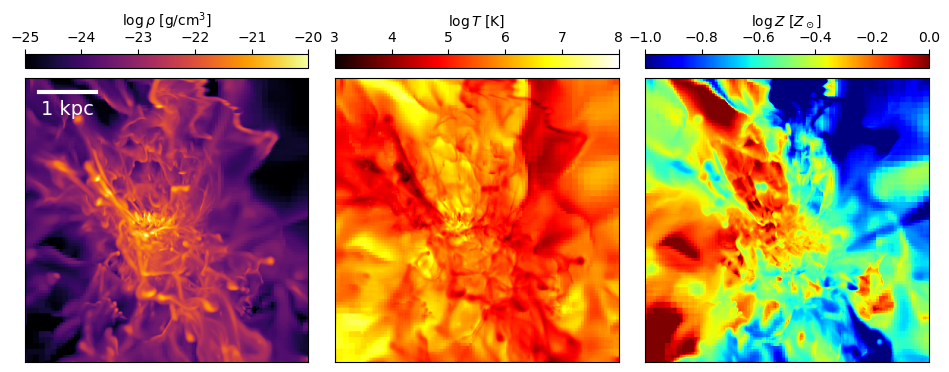

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

size_img = 5 * const.kpc

img = sim.proj_axis('density', idx_axis=X, weight='density', size_img=size_img)
im = sim.plot_img(img, ax=axs[0], do_log=True, cmap='inferno', vmin=1e-25, vmax=1e-20, size_img=size_img)
add_cbar_to_ax(im, ax=axs[0], label=r'$\log \rho$ [${\rm g/cm^3}$]', orientation='horizontal')

img = sim.proj_axis('temp', idx_axis=X, weight='density', size_img=size_img)
im = sim.plot_img(img, ax=axs[1], do_log=True, cmap='hot', vmin=1e3, vmax=1e8, size_img=size_img)
add_cbar_to_ax(im, ax=axs[1], label=r'$\log T$ [${\rm K}$]', orientation='horizontal')

# img = sim.proj_axis('pressure', idx_axis=X, weight='density', size_img=size_img)
# im = sim.plot_img(img, ax=axs[2], do_log=True, cmap='jet', vmin=1e-13, vmax=1e-8, size_img=size_img)
# add_cbar_to_ax(im, ax=axs[2], label=r'$\log p$ [${\rm cm^2/s^2}$]', orientation='horizontal')

img = sim.proj_axis('metallicity', idx_axis=X, weight='density', size_img=size_img)
im = sim.plot_img(img / const.Z_sol, ax=axs[2], do_log=True, cmap='jet', vmin=1e-1, vmax=1e0, size_img=size_img)
add_cbar_to_ax(im, ax=axs[2], label=r'$\log Z$ [$Z_\odot$]', orientation='horizontal')

for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
sim.add_dis_to_ax(axs[0], 1*const.kpc, size_img=size_img)


### PDF

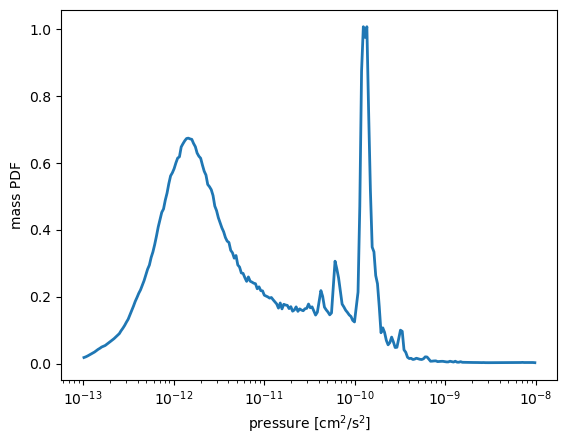

In [34]:
r = norm(sim.coord)
cond = r < 10 * const.kpc

pressure1d, pdf = calc_hist(sim.pressure[cond], vmin=1e-13, vmax=1e-8, weight=sim.density[cond], nbins=256, do_log=True, do_norm=True)
plt.xscale('log')
plt.xlabel(r'pressure [${\rm cm^2/s^2}$]')
plt.ylabel('mass PDF')

plt.plot(pressure1d, pdf, lw=2)


In [3]:
sim0p2 = Sim(9, "mstar0p2", "data_d41_l1_b5.npz")
sim1p0 = Sim(9, "fiducial", "data_d45_l1_b5.npz")
sim5p0 = Sim(9, "mstar5p0", "data_d39_l1_b5.npz")
sim_list = [sim0p2, sim1p0, sim5p0]


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.


/tmp/ipykernel_3416061/1336164782.py:17: RuntimeWarning: divide by zero encountered in divide
  scale1d, psd1d = calc_hist(1/k, weight=psd, do_log=True, vmin=(10 * const.pc), vmax=(1000 * const.pc), nbins=128)


Saved figure as 'densityPSD-020520241756.png'


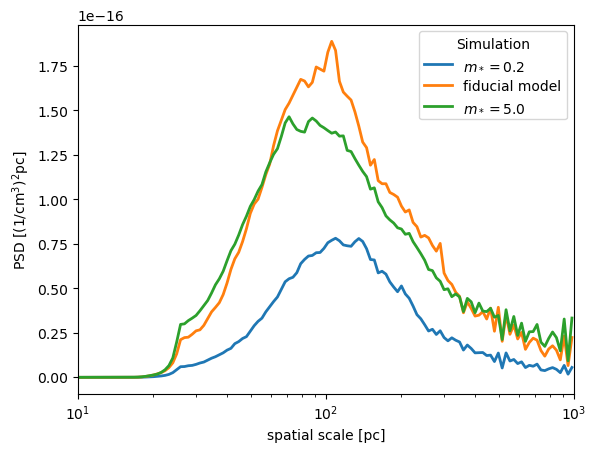

In [320]:
for sim in sim_list:
    
    # compute wavenumber array
    freq = fftshift(fftfreq(int(sim.N), d=sim.dx))
    kx = freq.reshape(sim.N, 1, 1)
    ky = freq.reshape(1, sim.N, 1)
    kz = freq.reshape(1, 1, sim.N)
    k = np.sqrt(kx**2 + ky**2 + kz**2)
    
    # compute window function
    blackman3d = blackman(sim.N)[:, None, None] * blackman(sim.N)[None, :, None] * blackman(sim.N)[None, None, :]
    blackman3d /= np.sum(blackman3d)
    
    # plot the PSD
    n_H = const.X_cosmo * sim.density / const.m_H
    psd = fftshift(np.abs(fftn(n_H * blackman3d))**2)
    scale1d, psd1d = calc_hist(1/k, weight=psd, do_log=True, vmin=(10 * const.pc), vmax=(1000 * const.pc), nbins=128)
    plt.plot(scale1d / const.pc, psd1d / const.pc, lw=2, label=sim.sim_latex)
    
plt.xscale('log')
plt.xlabel('spatial scale [pc]')
plt.ylabel(r'PSD [${\rm (1/cm^3)^2 pc}$]')
plt.legend(title="Simulation", fontsize=10)
plt.xlim(10, 1000)

save_fig('densityPSD')


Saved figure as 'velocityPSD-020520241728.png'


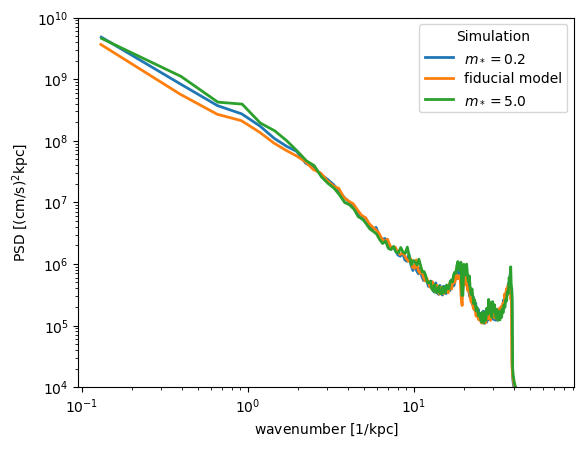

In [267]:
for sim in sim_list:
    
    freq = fftshift(fftfreq(int(sim.N), d=sim.dx))
    kx = freq.reshape(sim.N, 1, 1)
    ky = freq.reshape(1, sim.N, 1)
    kz = freq.reshape(1, 1, sim.N)
    k = np.sqrt(kx**2 + ky**2 + kz**2)
    
    psd = fftshift(np.abs(fftn(sim.vel))**2)
    k1d, psd1d = calc_hist(k, weight=psd, do_log=False)
    plt.plot(k1d * const.kpc, psd1d / const.kpc, lw=2, label=sim.sim_latex)
    
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'wavenumber [${\rm 1/kpc}$]')
plt.ylabel(r'PSD [${\rm (cm/s)^2 kpc}$]')
plt.legend(title="Simulation", fontsize=10)
plt.ylim(1e4, 1e10)

save_fig('velocityPSD')


Text(0, 0.5, '${\\rm d}M / {\\rm d}(\\log \\rho)$ [$10^9 M_\\odot$]')

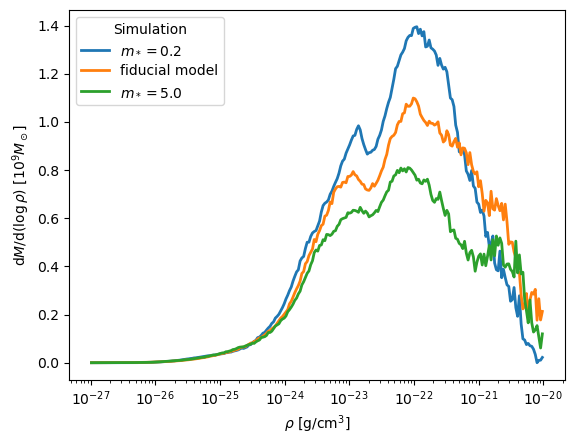

In [5]:
for sim in sim_list:
    cond = norm(sim.coord) < 2.5*const.kpc
    density1d, pdf = calc_hist(sim.density[cond], vmin=1e-27, vmax=1e-20, weight=(sim.density*sim.dx**3)[cond], nbins=256, do_log=True, do_norm=False)
    bin_width = np.log10(density1d)[1] - np.log10(density1d)[0]
    plt.plot(density1d, pdf / const.M_sol / 10**9 / bin_width, lw=2, label=sim.sim_latex)
    
plt.legend(title="Simulation", fontsize=10)
plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]')
plt.ylabel(r'${\rm d}M / {\rm d}(\log \rho)$ [$10^9 M_\odot$]')

#save_fig('density-pdf-comp')


Saved figure as 'density-vol-pdf-comp-020420242247.png'


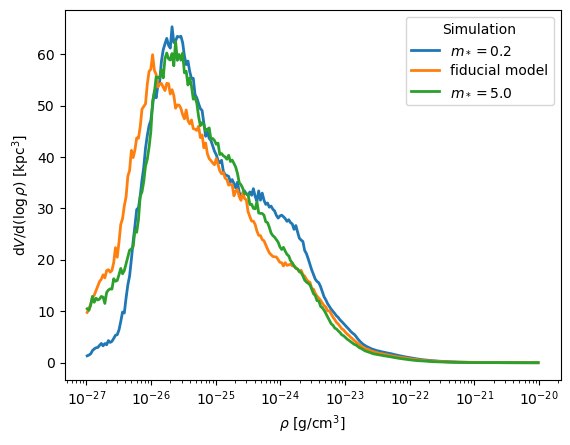

In [45]:
for sim in sim_list:
    density1d, pdf = calc_hist(sim.density, vmin=1e-27, vmax=1e-20, weight=np.full_like(sim.density, sim.dx**3), nbins=256, do_log=True, do_norm=False)
    bin_width = np.log10(density1d)[1] - np.log10(density1d)[0]
    plt.plot(density1d, pdf / const.kpc**3 / bin_width, lw=2, label=sim.sim_latex)
    
plt.legend(title="Simulation", fontsize=10)
plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]')
plt.ylabel(r'${\rm d}V / {\rm d}(\log \rho)$ [${\rm kpc^3}$]')

save_fig('density-vol-pdf-comp')


Saved figure as 'temp-pdf-comp-020420242245.png'


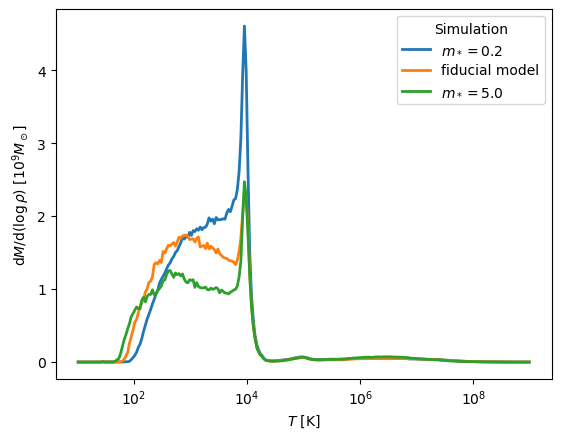

In [41]:
for sim in sim_list:
    temp1d, pdf = calc_hist(sim.temp, vmin=1e1, vmax=1e9, weight=(sim.density*sim.dx**3), nbins=256, do_log=True, do_norm=False)
    bin_width = np.log10(temp1d)[1] - np.log10(temp1d)[0]
    plt.plot(temp1d, pdf / const.M_sol / 10**9 / bin_width, lw=2, label=sim.sim_latex)
    
plt.legend(title="Simulation", fontsize=10)
plt.xscale('log')
plt.xlabel(r'$T$ [${\rm K}$]')
plt.ylabel(r'${\rm d}M / {\rm d}(\log \rho)$ [$10^9 M_\odot$]')

save_fig('temp-pdf-comp')


Saved figure as 'temp-vol-pdf-comp-020420242248.png'


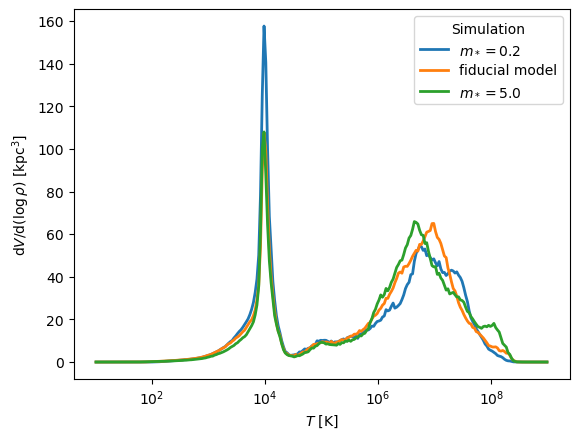

In [47]:
for sim in sim_list:
    temp1d, pdf = calc_hist(sim.temp, vmin=1e1, vmax=1e9, weight=np.full_like(sim.density, sim.dx**3), nbins=256, do_log=True, do_norm=False)
    bin_width = np.log10(temp1d)[1] - np.log10(temp1d)[0]
    plt.plot(temp1d, pdf / const.kpc**3 / bin_width, lw=2, label=sim.sim_latex)
    
plt.legend(title="Simulation", fontsize=10)
plt.xscale('log')
plt.xlabel(r'$T$ [${\rm K}$]')
plt.ylabel(r'${\rm d}V / {\rm d}(\log \rho)$ [${\rm kpc^3}$]')

save_fig('temp-vol-pdf-comp')


Saved figure as 'rhoprof-comp-020520241204.png'


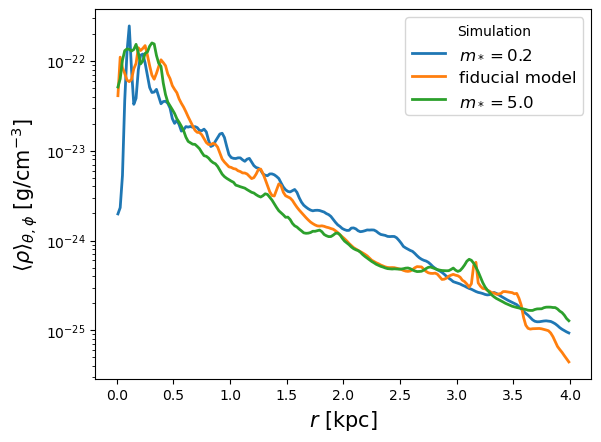

In [65]:
coord_center_0p2 = np.array([-1.10186974e+21, -8.17748045e+20, -2.56226731e+20])
coord_center_1p0 = np.array([-7.54365311e+20, -6.04679912e+20, -3.84642117e+20])
coord_center_5p0 = np.array([-6.42964894e+20, -6.75958211e+20, -8.87190791e+19])
coord_center_list = [coord_center_0p2, coord_center_1p0, coord_center_5p0]

for sim, coord_center in zip(sim_list, coord_center_list):
    
    coord_rel_center = sim.coord - coord_center[:, None, None, None]
    r_center = np.sqrt(np.sum(coord_rel_center**2, axis=0))
    r_1d, rho_1d = calc_profile1d(r_center, sim.density, vmin=0, vmax=4*const.kpc, do_log=False, nbins=200)
    plt.plot(r_1d / const.kpc, rho_1d, lw=2, label=sim.sim_latex)

plt.xlabel(r'$r$ [kpc]', fontsize=15)
plt.ylabel(r'$\langle \rho \rangle_{\theta, \phi}$ [${\rm g/cm^{-3}}$]', fontsize=15)
plt.yscale('log')
plt.legend(title='Simulation', fontsize=12)

#save_fig("rhoprof-comp")


Saved figure as 'rhostdprof-comp-020520241211.png'


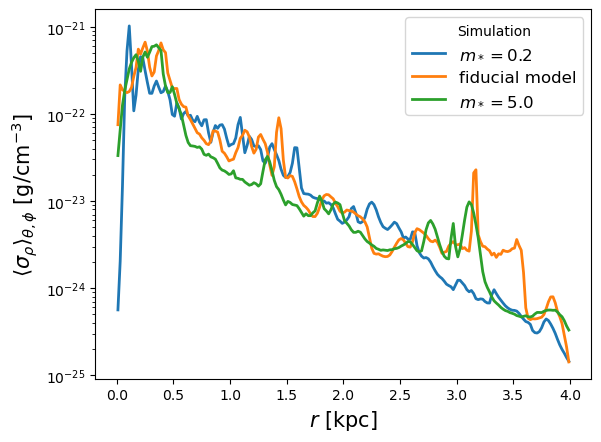

In [70]:
coord_center_0p2 = np.array([-1.10186974e+21, -8.17748045e+20, -2.56226731e+20])
coord_center_1p0 = np.array([-7.54365311e+20, -6.04679912e+20, -3.84642117e+20])
coord_center_5p0 = np.array([-6.42964894e+20, -6.75958211e+20, -8.87190791e+19])
coord_center_list = [coord_center_0p2, coord_center_1p0, coord_center_5p0]

for sim, coord_center in zip(sim_list, coord_center_list):
    
    coord_rel_center = sim.coord - coord_center[:, None, None, None]
    r_center = np.sqrt(np.sum(coord_rel_center**2, axis=0))
    r_1d, rho_1d = calc_profile1d(r_center, sim.density, vmin=0, vmax=4*const.kpc, do_log=False, nbins=200)
    _, rhosq_1d = calc_profile1d(r_center, sim.density**2, vmin=0, vmax=4*const.kpc, do_log=False, nbins=200)
    rhostd_1d = np.sqrt(rhosq_1d - rho_1d**2)
    plt.plot(r_1d / const.kpc, rhostd_1d, lw=2, label=sim.sim_latex)

plt.xlabel(r'$r$ [kpc]', fontsize=15)
plt.ylabel(r'$\langle \sigma_\rho \rangle_{\theta, \phi}$ [${\rm g/cm^{-3}}$]', fontsize=15)
plt.yscale('log')
plt.legend(title='Simulation', fontsize=12)

# save_fig("rhostdprof-comp")


### phasespace

Text(0.5, 1.0, 'fiducial model')

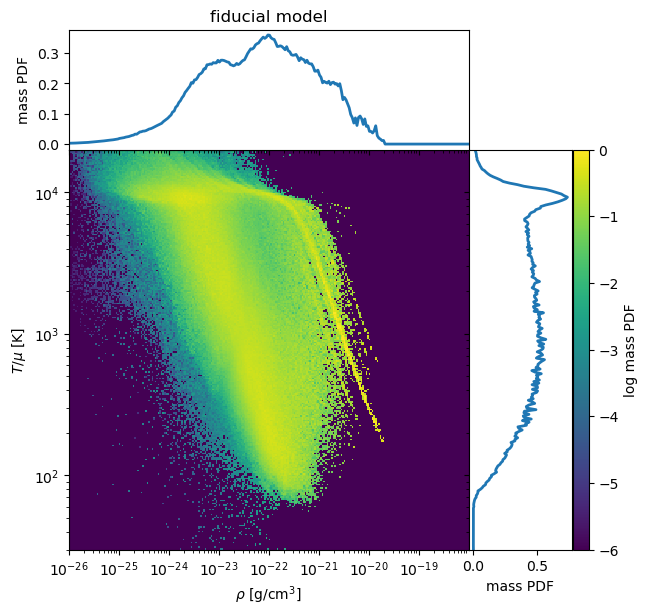

In [8]:
sim = sim1p0

axs, density2d, temp2d, pdf, im = plot_pdf2d(sim.density, sim.temp, 1e-26, 1e-18, 3e1, 2e4, 1e-6, 1e0, weight=sim.density, nbins=256)
add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='log mass PDF')

axs[0].set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
axs[0].set_ylabel(r'$T/\mu$ [${\rm K}$]')
axs[1].set_ylabel('mass PDF')
axs[2].set_xlabel('mass PDF')
axs[1].set_title(sim.sim_latex)

# densitygrid, tempgrid = np.meshgrid(density2d, temp2d)
# dx = 10*const.pc
# mach_turb = 1.0
# b_turb = 1.0
# energy_turb = 3/2 * mach_turb**2 * tempgrid * const.k_B / const.m_p
# eps_sf = calc_eps_sf2(densitygrid, energy_turb, tempgrid, dx, b_turb=b_turb)
# axs[0].contour(densitygrid, tempgrid, eps_sf, levels=[0.1], colors='red', linewidths=2)

#temp_cut = broken_powerlaw(density2d, 8e3, 2.5e-22, 0, -1, 3)
#axs[0].plot(density2d, temp_cut, color='red', lw=2)

#save_fig('phase-5p0')


Saved figure as 'phasespace2_fiducial-020420242233.png'


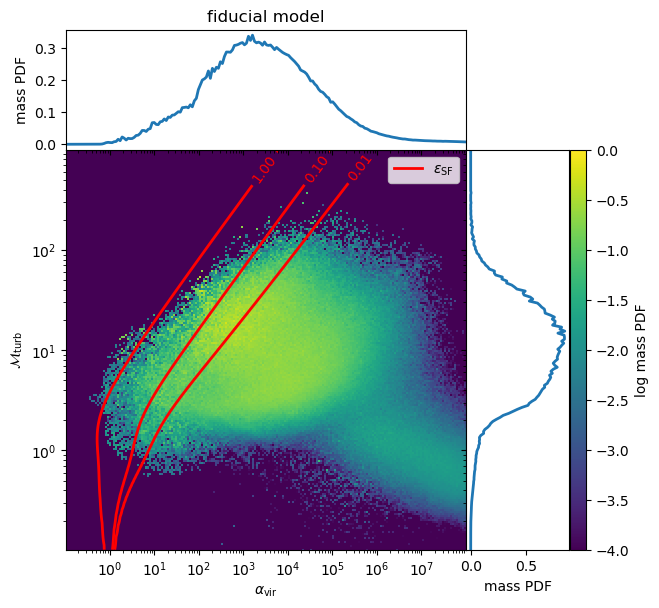

In [24]:
axs, alpha_vir2d, mach_turb2d, pdf, im = plot_pdf2d(sim.alpha_vir, sim.mach_turb, 1e-1, 1e8, 1e-1, 1e3, 1e-4, 1e0, weight=sim.density, nbins=200)
add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='log mass PDF')

alpha_vir2d, mach_turb2d = np.meshgrid(alpha_vir2d, mach_turb2d, indexing='ij')
eps_sf = calc_eps_sf(alpha_vir2d, mach_turb2d, b_turb=1.0)
cs = axs[0].contour(alpha_vir2d, mach_turb2d, eps_sf, levels=[1e-2, 1e-1, 1e0], colors='red', linewidths=2)
plt.clabel(cs, [1e-2, 1e-1, 1e0])
add_custleg_to_ax([r'$\varepsilon_{\rm SF}$'], ['red'], ax=axs[0])

axs[0].set_xlabel(r'$\alpha_{\rm vir}$')
axs[0].set_ylabel(r'$\mathcal{M}_{\rm turb}$')
axs[1].set_ylabel('mass PDF')
axs[2].set_xlabel('mass PDF')
axs[1].set_title(sim.sim_latex)

save_fig('phasespace2_fiducial')


### angular momentum

In [53]:
r_sph_init = 5 * const.kpc
frac_shrink = 0.98
num_iter = 10

r_sph_list = np.zeros((num_iter + 1)) 
r_sph_list[0] = r_sph_init
coord_center_list = np.zeros((num_iter + 1, 3))

for i in range(num_iter):
    coord_rel_center = sim.coord - coord_center_list[i, :, None, None, None]
    r_rel_center = np.sqrt(np.sum(coord_rel_center**2, axis=0))
    cond_sph = r_rel_center < r_sph_list[i]
    coord_center_list[i + 1] = np.sum(cond_sph * sim.coord * sim.density, axis=(1,2,3)) / np.sum(cond_sph * sim.density)
    r_sph_list[i + 1] = r_sph_list[i] * frac_shrink
    print(i, end="")

coord_center = coord_center_list[-1]
coord_rel_center = sim.coord - coord_center[:, None, None, None]
r_center = np.sqrt(np.sum(coord_rel_center**2, axis=0))
    

0123456789

Text(0.5, 1.0, '$m_* = 0.2$')

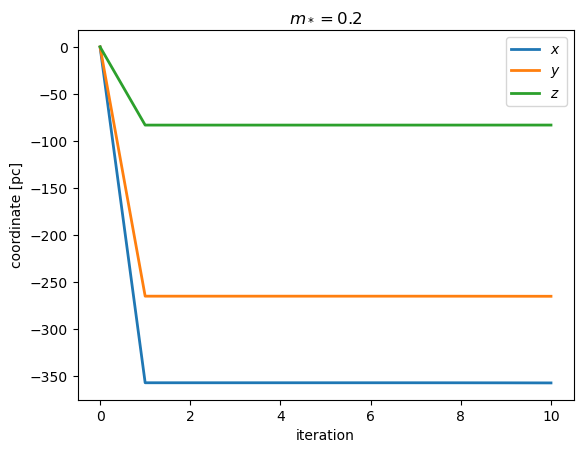

In [54]:
# plt.plot(radius_sphere_list / const.pc, color='grey', lw=2, label=r'$r_{\rm sph}$')
plt.plot(coord_center_list[:, X] / const.pc, label=r'$x$', lw=2, color='C0')
plt.plot(coord_center_list[:, Y] / const.pc, label=r'$y$', lw=2, color='C1')
plt.plot(coord_center_list[:, Z] / const.pc, label=r'$z$', lw=2, color='C2')

plt.legend()
plt.xlabel('iteration')
plt.ylabel(r'coordinate [pc]')
plt.title(sim.sim_latex)

#plt.ylim(-300, 300)


Text(0.5, 1.0, '$m_* = 0.2$')

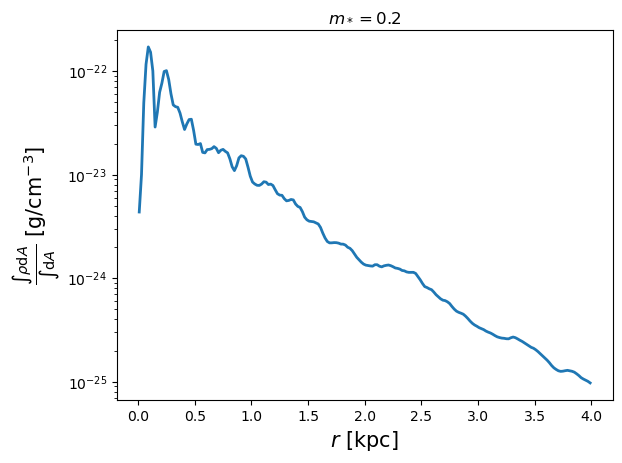

In [28]:
r_1d, rho_1d = calc_profile1d(r_center, sim.density, vmin=0, vmax=4*const.kpc, do_log=False, nbins=200)
plt.plot(r_1d / const.kpc, rho_1d, lw=2)

plt.xlabel(r'$r$ [kpc]', fontsize=15)
plt.ylabel(r'$\frac{\int \rho {\rm d}A}{\int {\rm d}A}$ [${\rm g/cm^{-3}}$]', fontsize=15)
plt.yscale('log')
plt.title(sim.sim_latex)


/home/za9132/analysis/functions.py:329: RuntimeWarning: invalid value encountered in divide
  field1d = weighted_field1d / weight1d


Text(0.5, 1.0, '$m_* = 0.2$')

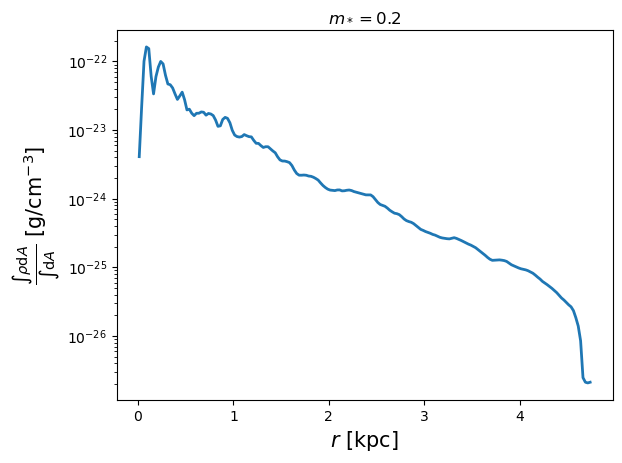

In [26]:
r_1d, rho_1d = calc_profile1d(r_center, sim.density, vmin=0, vmax=5*const.kpc, do_log=False, nbins=200)
plt.plot(r_1d / const.kpc, rho_1d, lw=2)

plt.xlabel(r'$r$ [kpc]', fontsize=15)
plt.ylabel(r'$\frac{\int \rho {\rm d}A}{\int {\rm d}A}$ [${\rm g/cm^{-3}}$]', fontsize=15)
plt.yscale('log')
plt.title(sim.sim_latex)


In [84]:
r_1d, vx_1d = calc_profile1d(r_center, sim.vel_vec[X], vmin=0, vmax=3*const.kpc, do_log=False, nbins=200, weight=sim.density, do_cum=True)
r_1d, vy_1d = calc_profile1d(r_center, sim.vel_vec[Y], vmin=0, vmax=3*const.kpc, do_log=False, nbins=200, weight=sim.density, do_cum=True)
r_1d, vz_1d = calc_profile1d(r_center, sim.vel_vec[Z], vmin=0, vmax=3*const.kpc, do_log=False, nbins=200, weight=sim.density, do_cum=True)


/home/za9132/analysis/functions.py:328: RuntimeWarning: invalid value encountered in divide
  field1d = np.cumsum(weighted_field1d) / np.cumsum(weight1d)


(-300.0, 300.0)

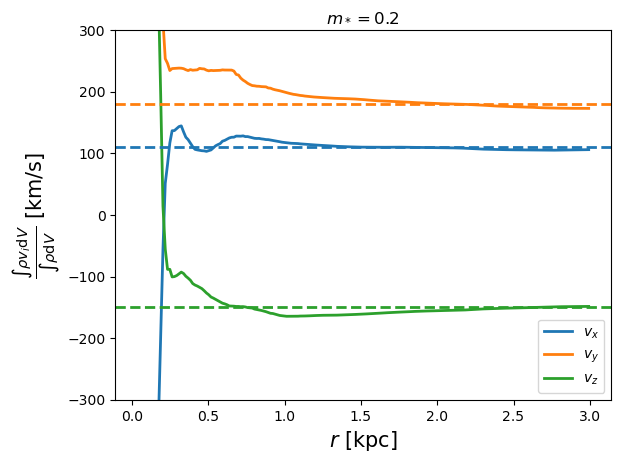

In [91]:
plt.plot(r_1d / const.kpc, vx_1d / const.km, lw=2, label=r'$v_x$', color='C0')
plt.plot(r_1d / const.kpc, vy_1d / const.km, lw=2, label=r'$v_y$', color='C1')
plt.plot(r_1d / const.kpc, vz_1d / const.km, lw=2, label=r'$v_z$', color='C2')

plt.xlabel(r'$r$ [kpc]', fontsize=15)
plt.ylabel(r"$\frac{\int \rho v_i {\rm d}V}{\int \rho {\rm d}V}$ [${\rm km/s}$]", fontsize=15)
plt.legend()
plt.title(sim.sim_latex)

vx_bulk = 110 * const.km
vy_bulk = 180 * const.km
vz_bulk = -150 * const.km

plt.axhline(y=vx_bulk / const.km, lw=2, linestyle='--', color='C0')
plt.axhline(y=vy_bulk / const.km, lw=2, linestyle='--', color='C1')
plt.axhline(y=vz_bulk / const.km, lw=2, linestyle='--', color='C2')

plt.ylim(-300, 300)

# save_fig('bturb0p3-vbulk')


In [92]:
vel_rel_bulk = sim.vel_vec - np.array([vx_bulk, vy_bulk, vz_bulk])[:, None, None, None]
l_mom = np.cross(coord_rel_center, vel_rel_bulk, axisa=0, axisb=0, axisc=0)

r_1d, lx_1d = calc_profile1d(r_center, l_mom[X], vmin=0, vmax=3*const.kpc, do_log=False, nbins=200, weight=sim.density, do_cum=True)
r_1d, ly_1d = calc_profile1d(r_center, l_mom[Y], vmin=0, vmax=3*const.kpc, do_log=False, nbins=200, weight=sim.density, do_cum=True)
r_1d, lz_1d = calc_profile1d(r_center, l_mom[Z], vmin=0, vmax=3*const.kpc, do_log=False, nbins=200, weight=sim.density, do_cum=True)

jx_1d = lx_1d / np.sqrt(lx_1d**2 + ly_1d**2 + lz_1d**2)
jy_1d = ly_1d / np.sqrt(lx_1d**2 + ly_1d**2 + lz_1d**2)
jz_1d = lz_1d / np.sqrt(lx_1d**2 + ly_1d**2 + lz_1d**2)


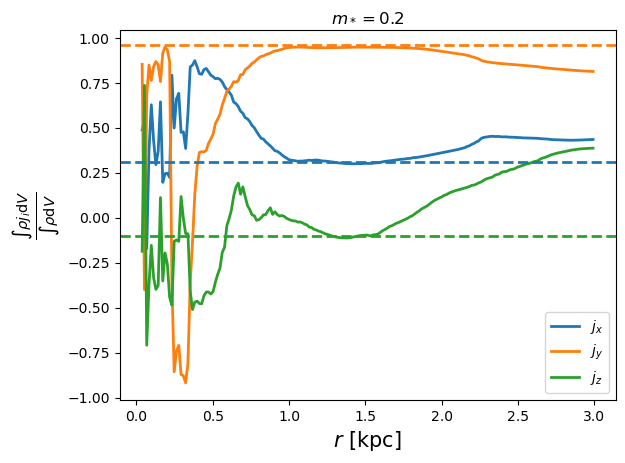

In [99]:
plt.plot(r_1d / const.kpc, jx_1d, lw=2, label=r'$j_x$', color='C0')
plt.plot(r_1d / const.kpc, jy_1d, lw=2, label=r'$j_y$', color='C1')
plt.plot(r_1d / const.kpc, jz_1d, lw=2, label=r'$j_z$', color='C2')

plt.xlabel(r'$r$ [kpc]', fontsize=15)
plt.ylabel(r"$\frac{\int \rho j_i {\rm d}V}{\int \rho {\rm d}V}$", fontsize=15)
plt.legend()
plt.title(sim.sim_latex)

j_disk = np.array([0.31, 0.96, -0.1])
#j_disk = j_disk / norm(j_disk)

plt.axhline(y=j_disk[X], lw=2, linestyle='--', color='C0')
plt.axhline(y=j_disk[Y], lw=2, linestyle='--', color='C1')
plt.axhline(y=j_disk[Z], lw=2, linestyle='--', color='C2')

# save_fig('bturb0p3-angmom')


[]

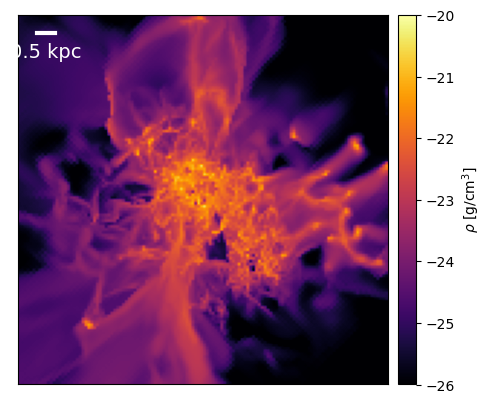

In [106]:
#coord_center = np.array([0.51035193, 0.51258252, 0.49281404]) * sim.length_unit - sim.left_edge
#j_disk = np.array([0.428354, 0.87663144, 0.21915786])

size_img = 10 * const.kpc
size_sample = 2 * const.kpc
num_pxl = 128
num_sample = 10000
vec_camera = np.cross(j_disk, np.array([1, 0, 0]))
#vec_camera = j_disk
vec_north = np.array([0.5, 0.5, 0])

vec_coord1, vec_coord2, img = sim.proj_anyaxis('density', coord_center=coord_center, size_img=size_img, size_sample=size_sample, vec_camera=vec_camera, num_pxl=num_pxl, vec_north=vec_north, weight='density')

ax = plt.gca()
im = sim.plot_img(img, size_img=size_img, vmin=1e-26, vmax=1e-20, cmap='inferno', do_log=True)
add_cbar_to_ax(im, ax=ax, label=r'$\rho$ [${\rm g/cm^3}$]')

sim.add_dis_to_ax(ax, 0.5*const.kpc, size_img=size_img)
ax.set_xticks([])
ax.set_yticks([])


[]

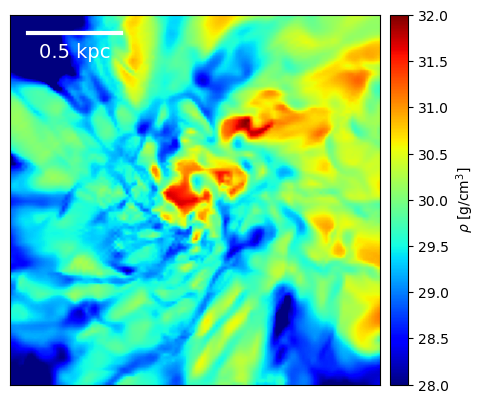

In [111]:
size_img = 2 * const.kpc
size_sample = 2 * const.kpc
num_pxl = 128
num_sample = 10000
#vec_camera = np.cross(j_disk, np.array([1, 0, 0]))
vec_camera = j_disk
vec_north = np.array([0.5, 0.5, 0])

vec_coord1, vec_coord2, img = sim.proj_anyaxis('entropy', coord_center=coord_center, size_img=size_img, size_sample=size_sample, vec_camera=vec_camera, num_pxl=num_pxl, vec_north=vec_north, weight='density')

ax = plt.gca()
im = sim.plot_img(img, size_img=size_img, vmin=1e28, vmax=1e32, cmap='jet', do_log=True)
add_cbar_to_ax(im, ax=ax, label=r'$\rho$ [${\rm g/cm^3}$]')

sim.add_dis_to_ax(ax, 0.5*const.kpc, size_img=size_img)
ax.set_xticks([])
ax.set_yticks([])
